In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x "/content/drive/MyDrive/Traffic_Sign_-2.rar" "/content/drive/MyDrive"

Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/MyDrive/Traffic_Sign_-2/Train/SpeedLimit/00004_00056_00010.png      76%  OK 
Extracting  /content/drive/MyDrive/Traffic_Sign_-2/Train/SpeedLimit/00004_00056_00011.png      76%  OK 
Extracting  /content/drive/MyDrive/Traffic_Sign_-2/Train/SpeedLimit/00004_00056_00012.png      76%  OK 
Extracting  /content/drive/MyDrive/Traffic_Sign_-2/Train/SpeedLimit/00004_00056_00013.png      76%  OK 
Extracting  /content/drive/MyDrive/Traffic_Sign_-2/Train/SpeedLimit/00004_00056_00014.png      76%  OK 
Extracting  /content/drive/MyDrive/Traffic_Sign_-2/Train/SpeedLimit/00004_00056_00015.png      76%  OK 
Extracting  /content/drive/MyDrive/Traffic_Sign_-2/Train/SpeedLimit/00004_00056_00016.png      76%  OK 
Extracting  /content/drive/MyDrive/Traffic_Sign_-2/Train/SpeedLimit/00004_00056_00017.png      76%  OK 
Extracting  /content/drive/MyDrive/Traffic_Si

In [2]:
train_dir = "/content/drive/MyDrive/Traffic_Sign_-2/Train"
test_dir = "/content/drive/MyDrive/Traffic_Sign_-2/Test"

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
import os
def count_files(directory):
  file_count = 0
  for root, dirs, files in os.walk(directory):
    file_count += len(files)
  return file_count

total_files = count_files(train_dir)
print("Total files in the folder:", total_files)

Total files in the folder: 16100


In [6]:
print("Num GPUs Available:", len(tf.config.list_physical_devices ('GPU')))

Num GPUs Available: 1


In [7]:
import os

# Initialize a dictionary to store the counts for each class
class_counts = {}

# Traverse through each folder in the root directory
for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)
    if os.path.isdir(folder_path):
        # Count the number of images in the current folder
        num_images = len(os.listdir(folder_path))
        # Store the count in the dictionary with the folder name as the key
        class_counts[folder_name] = num_images

# Print the class counts
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of Images: {count}")

Class: Crossings, Number of Images: 1828
Class: DIrection, Number of Images: 2968
Class: No Entry, Number of Images: 2938
Class: SpeedLimit, Number of Images: 6688
Class: Cautions, Number of Images: 1678


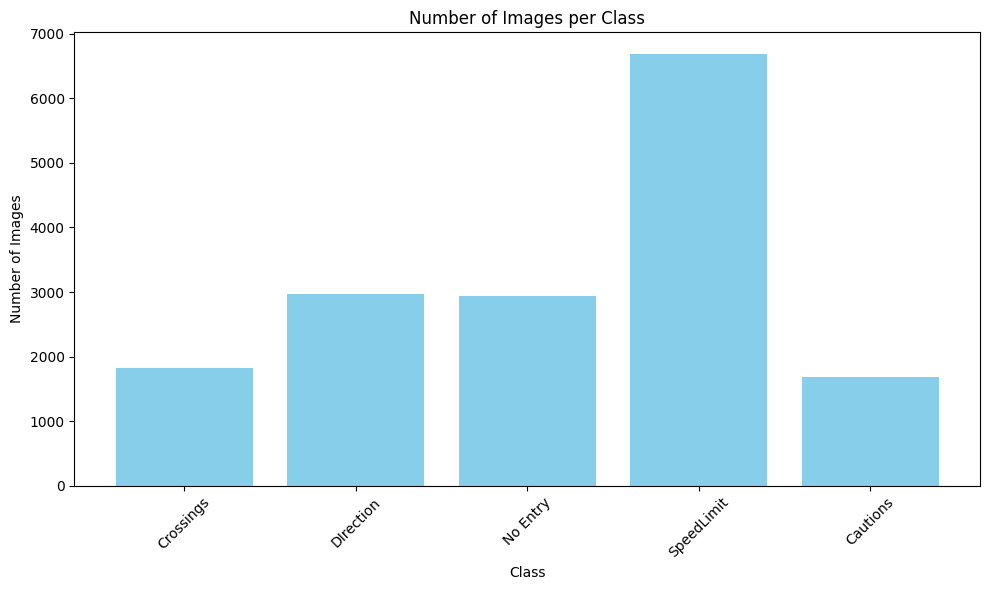

In [8]:
import matplotlib.pyplot as plt

# Class names and counts from the result
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
batch_size = 32
img_height = 150
img_width = 150
num_classes = 5

In [10]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    shuffle = True,
    seed=123
)

Found 16100 files belonging to 5 classes.
Using 12880 files for training.


['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']


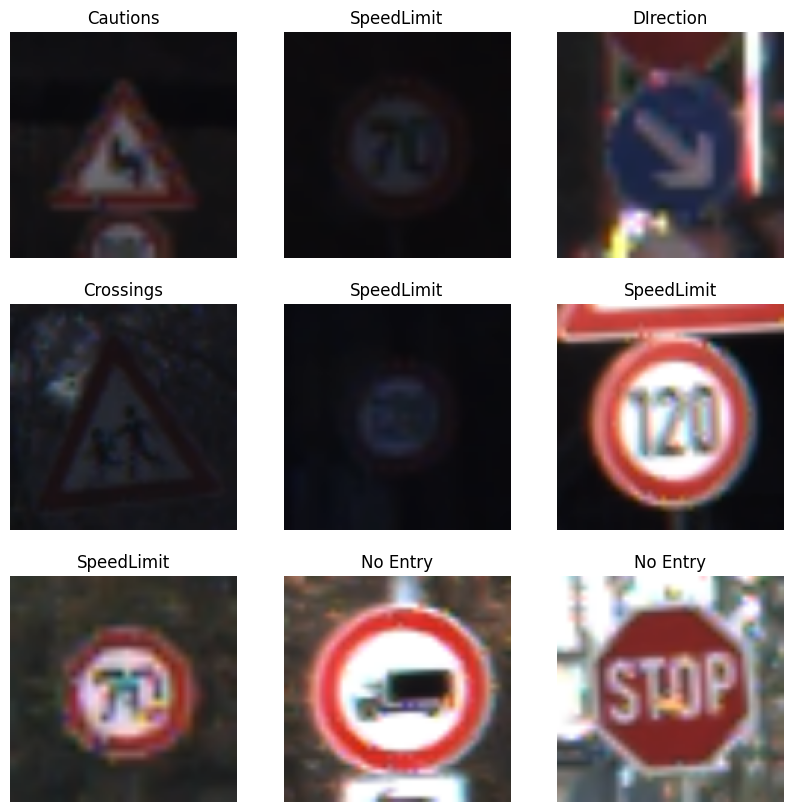

In [13]:
import matplotlib.pyplot  as plt
class_names = train_data.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
from PIL import Image
corrupted_images = []
classes = os.listdir(train_dir)
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        try:
            img = Image.open(image_path)
            img.verify()  # Verify if image is valid
        except (IOError, SyntaxError) as e:
            corrupted_images.append(image_path)
            # os.remove(image_path)  # Remove corrupted image
            print(f"Removed corrupted image: {image_path}")


In [15]:
if corrupted_images:
    print("Corrupted images found:")
    for image_path in corrupted_images:
        print(image_path)
else:
    print("No corrupted images found.")



No corrupted images found.


In [16]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    shuffle = True,
    subset="validation",
    seed=123
)

Found 16100 files belonging to 5 classes.
Using 3220 files for validation.


In [17]:
train_data = train_data.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_data = val_data.map(lambda x, y: (x, tf.one_hot(y, num_classes)))


In [18]:
import numpy as np

# Count the number of images in each class for training dataset
train_class_counts = {}
for images, labels in train_data:
    for label in labels.numpy():
        label_tuple = tuple(label.tolist())  # Convert NumPy array to Python tuple
        if label_tuple not in train_class_counts:
            train_class_counts[label_tuple] = 1
        else:
            train_class_counts[label_tuple] += 1

# Count the number of images in each class for validation dataset
val_class_counts = {}
for images, labels in val_data:
    for label in labels.numpy():
        label_tuple = tuple(label.tolist())  # Convert NumPy array to Python tuple
        if label_tuple not in val_class_counts:
            val_class_counts[label_tuple] = 1
        else:
            val_class_counts[label_tuple] += 1

# Display the number of images in each class for training dataset
print("Training Dataset:")
for class_index, count in train_class_counts.items():
    print(f"Class {class_index}: {count} images")

# Display the number of images in each class for validation dataset
print("\nValidation Dataset:")
for class_index, count in val_class_counts.items():
    print(f"Class {class_index}: {count} images")

# Show some sample images from each class
num_samples_per_class = 5
for class_index in range(num_classes):
    print(f"\nSample images for class {class_index}:")
    class_samples = []
    for images, labels in train_data:
        for image, label in zip(images.numpy(), labels.numpy()):
            if tuple(label.tolist()) == class_index:  # Convert label to Python tuple for comparison
                class_samples.append(image)
                if len(class_samples) >= num_samples_per_class:
                    break
        if len(class_samples) >= num_samples_per_class:
            break

    # Plot the sample images for this class
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_samples):
        plt.subplot(1, num_samples_per_class, i+1)
        plt.imshow(image.astype("uint8"))
        plt.axis("off")
    plt.show()


Training Dataset:
Class (0.0, 0.0, 0.0, 0.0, 1.0): 5358 images
Class (0.0, 0.0, 0.0, 1.0, 0.0): 2349 images
Class (1.0, 0.0, 0.0, 0.0, 0.0): 1347 images
Class (0.0, 0.0, 1.0, 0.0, 0.0): 2383 images
Class (0.0, 1.0, 0.0, 0.0, 0.0): 1443 images

Validation Dataset:
Class (0.0, 0.0, 0.0, 0.0, 1.0): 1330 images
Class (0.0, 0.0, 1.0, 0.0, 0.0): 585 images
Class (1.0, 0.0, 0.0, 0.0, 0.0): 331 images
Class (0.0, 1.0, 0.0, 0.0, 0.0): 385 images
Class (0.0, 0.0, 0.0, 1.0, 0.0): 589 images

Sample images for class 0:


<Figure size 1000x500 with 0 Axes>


Sample images for class 1:


<Figure size 1000x500 with 0 Axes>


Sample images for class 2:


<Figure size 1000x500 with 0 Axes>


Sample images for class 3:


<Figure size 1000x500 with 0 Axes>


Sample images for class 4:


<Figure size 1000x500 with 0 Axes>

In [19]:
model = Sequential([
    Flatten(input_shape=(img_height, img_width, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [20]:

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 8648709 (32.99 MB)
Trainable params: 8648709 (32.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
history = model.fit(train_data, epochs=10, validation_data=val_data)


Epoch 1/10
403/403 [==============================] - 55s 130ms/step - loss: 358.0320 - accuracy: 0.7234 - val_loss: 80.2969 - val_accuracy: 0.8351
Epoch 2/10
403/403 [==============================] - 48s 117ms/step - loss: 63.8164 - accuracy: 0.8447 - val_loss: 117.2878 - val_accuracy: 0.7972
Epoch 3/10
403/403 [==============================] - 45s 111ms/step - loss: 39.9231 - accuracy: 0.8726 - val_loss: 20.0652 - val_accuracy: 0.9149
Epoch 4/10
403/403 [==============================] - 46s 113ms/step - loss: 40.5201 - accuracy: 0.8673 - val_loss: 33.9652 - val_accuracy: 0.8699
Epoch 5/10
403/403 [==============================] - 48s 117ms/step - loss: 21.5513 - accuracy: 0.8749 - val_loss: 4.6735 - val_accuracy: 0.9236
Epoch 6/10
403/403 [==============================] - 48s 117ms/step - loss: 7.4623 - accuracy: 0.9005 - val_loss: 8.4003 - val_accuracy: 0.8817
Epoch 7/10
403/403 [==============================] - 51s 125ms/step - loss: 5.9621 - accuracy: 0.9038 - val_loss: 2.97

In [22]:
loss, accuracy = model.evaluate(val_data)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

101/101 [==============================] - 10s 88ms/step - loss: 1.5384 - accuracy: 0.9450
Test Loss: 1.5384445190429688
Test Accuracy: 0.9450310468673706


In [24]:
def predict_labels(dataset, model):
    predicted_labels = []
    true_labels = []
    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1))
        true_labels.extend(labels)
    return predicted_labels, true_labels

In [25]:
val_predicted_labels, val_true_labels = predict_labels(val_data, model)

1/1 [==============================] - 0s 99ms/step


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred = model.evaluate(val_data)


CNN

In [ ]:
data_dir = "/content/drive/MyDrive/Traffic_Sign_-2/Train"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 16100 files belonging to 5 classes.
Using 12075 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 16100 files belonging to 5 classes.
Using 4025 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']


In [ ]:

for image_batch, labels_batch in train_ds:
 print(image_batch.shape)
 print(labels_batch.shape)
 break

(32, 150, 150, 3)
(32,)


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding= 'valid'))
model.add(Conv2D (128, kernel_size=(3,3), padding= 'valid', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding= 'valid'))

In [ ]:

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))  # Using len(class_names) to automatically adjust output size
num_classes = len(class_names)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

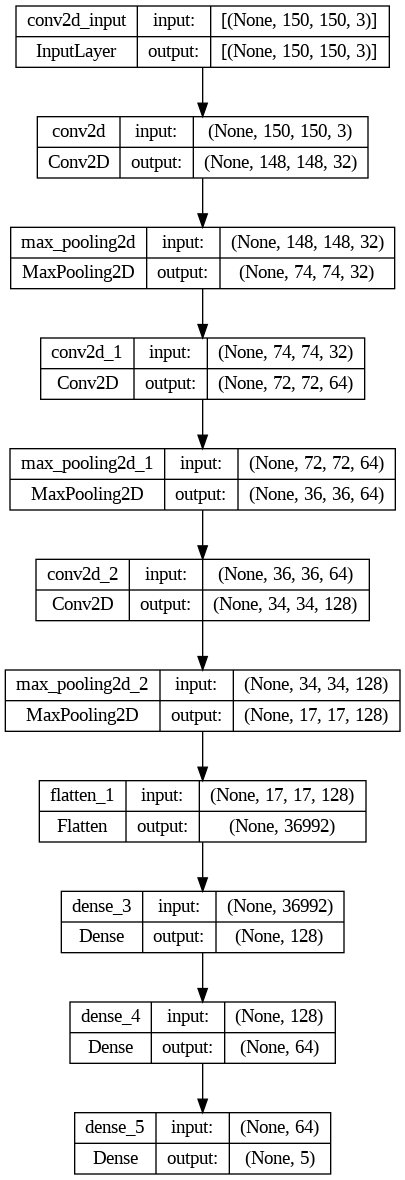

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,

)


Epoch 1/10
378/378 [==============================] - 57s 138ms/step - loss: 1.9138 - accuracy: 0.8682 - val_loss: 0.1296 - val_accuracy: 0.9563
Epoch 2/10
378/378 [==============================] - 52s 137ms/step - loss: 0.1104 - accuracy: 0.9657 - val_loss: 0.1191 - val_accuracy: 0.9635
Epoch 3/10
378/378 [==============================] - 52s 136ms/step - loss: 0.1375 - accuracy: 0.9602 - val_loss: 0.0659 - val_accuracy: 0.9819
Epoch 4/10
378/378 [==============================] - 52s 135ms/step - loss: 0.0299 - accuracy: 0.9897 - val_loss: 0.0243 - val_accuracy: 0.9938
Epoch 5/10
378/378 [==============================] - 62s 161ms/step - loss: 0.0338 - accuracy: 0.9908 - val_loss: 0.0291 - val_accuracy: 0.9925
Epoch 6/10
378/378 [==============================] - 60s 158ms/step - loss: 0.0304 - accuracy: 0.9928 - val_loss: 0.0532 - val_accuracy: 0.9871
Epoch 7/10
378/378 [==============================] - 51s 134ms/step - loss: 0.0508 - accuracy: 0.9862 - val_loss: 0.1206 - val_ac

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

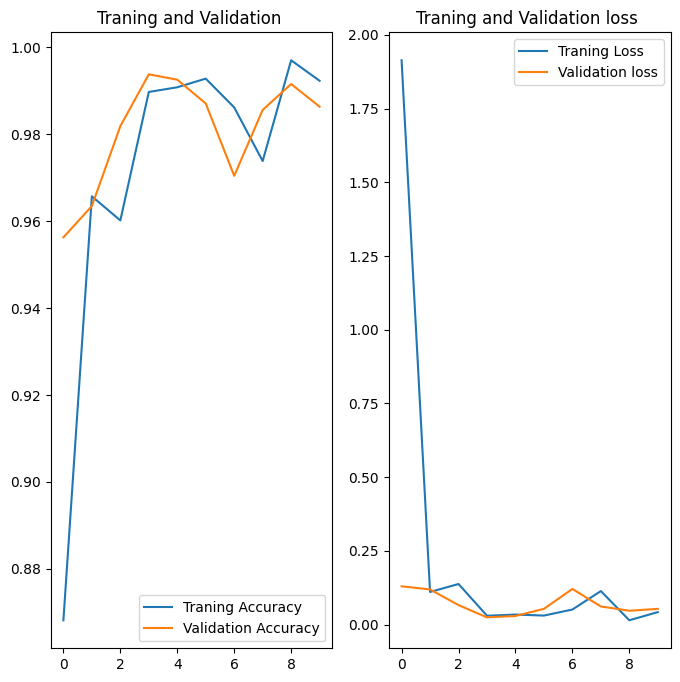

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Traning Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Traning and Validation ')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Traning Loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Traning and Validation loss ')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Traffic_Sign_-2/Test",
    image_size=(160, 160),
    batch_size=32
)

Found 10 files belonging to 1 classes.


In [ ]:
def unseen_data_test(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))  # Resize to match model input shape
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class_index = tf.argmax(predictions[0], axis=-1)
    predicted_class = class_names[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f'predicted class: {predicted_class}')
    for i, class_name in enumerate(class_names):
        print(f'Probability of {class_name}: {predictions[0][i]:.4f}')

    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.title(f'Predicted class: {predicted_class}')
    plt.show()


1/1 [==============================] - 0s 319ms/step
predicted class: SpeedLimit
Probability of Cautions: 0.0000
Probability of Crossings: 0.0000
Probability of DIrection: 0.0000
Probability of No Entry: 0.0000
Probability of SpeedLimit: 1.0000


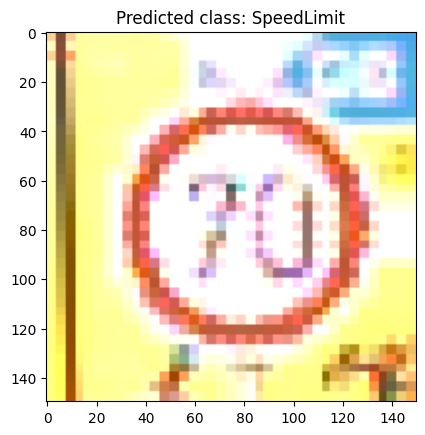

In [ ]:
unseen_data_test("/content/drive/MyDrive/Traffic_Sign_-2/Test/abc/00004_00002_00011.png", model)

1/1 [==============================] - 0s 19ms/step
predicted class: DIrection
Probability of Cautions: 0.0000
Probability of Crossings: 0.0005
Probability of DIrection: 0.9977
Probability of No Entry: 0.0001
Probability of SpeedLimit: 0.0017


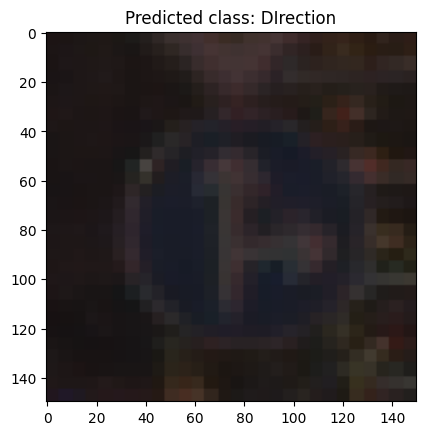

In [ ]:
unseen_data_test("/content/drive/MyDrive/Traffic_Sign_-2/Test/abc/00036_00000_00002.png", model)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
def predict_labels(dataset, model):
    predicted_labels = []
    true_labels = []
    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1))
        true_labels.extend(labels)
    return predicted_labels, true_labels


In [ ]:
# Predict labels for the validation dataset
val_predicted_labels, val_true_labels = predict_labels(val_ds, model)

1/1 [==============================] - 0s 21ms/step


In [ ]:
conf_matrix = confusion_matrix(val_true_labels, val_predicted_labels)


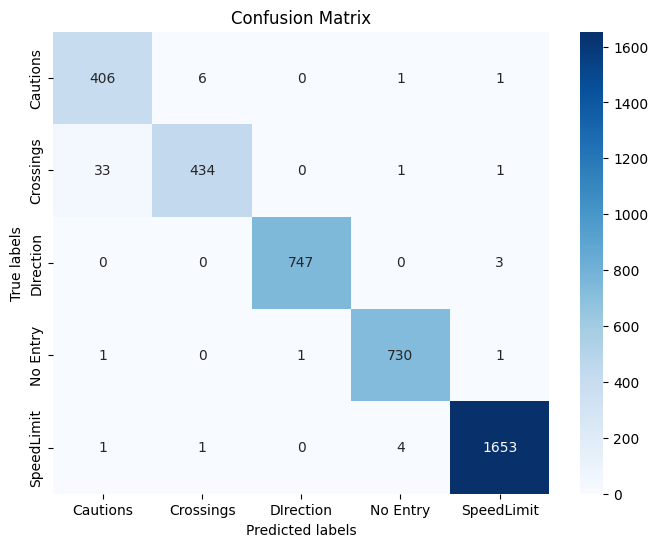

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Transfer Learning

In [ ]:
train_dir = '/content/drive/MyDrive/Traffic_Sign_-2/Train'
test_dir = '/content/drive/MyDrive/Traffic_Sign_-2/Test'

In [ ]:
# Hyper-parameters:
batch_size = 40
img_height = 300
img_width = 300
# Set Resize variable
IMAGE_SIZE = [300, 300] #   This is my desired image size ...  and also ResNet50 accepts image of 300•300.


In [ ]:
training_set = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.25,
  subset = "training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 16100 files belonging to 5 classes.
Using 12075 files for training.


In [ ]:
test_set = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.25,
  subset = "validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16100 files belonging to 5 classes.
Using 4025 files for validation.


In [ ]:
#   Printing out number of Classes
class_names = training_set.class_names
print(class_names)

['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']


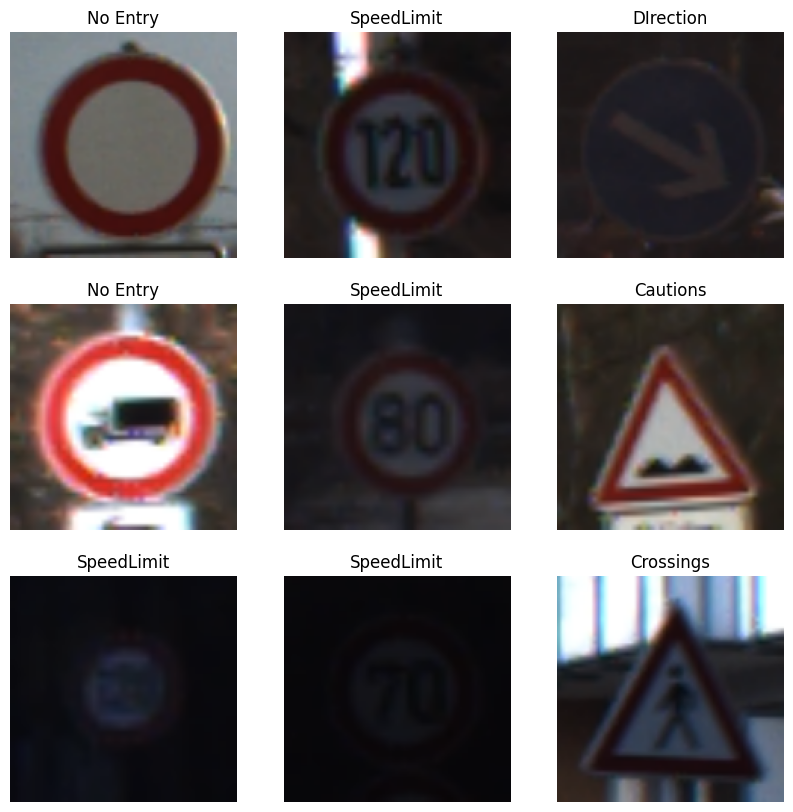

In [ ]:
import matplotlib.pyplot  as plt


plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
  resnet = ResNet50(
  input_shape= IMAGE_SIZE + [3],  # Assuming 3 channels for RGB images
  weights='imagenet',             # Default weights
  include_top=False
)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 306, 306, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
from glob import glob
for layer in resnet.layers:
  layer.trainable = True

# This will let us use the default wiight used by  the imagenet.

# Useful for gettingnumber of output classes.
# folders = glob ('../input/car-brand-image-dataset/Train/*')
folders = glob("/content/drive/MyDrive/Traffic_Sign_-2/Train" + '/*')
folders


['/content/drive/MyDrive/Traffic_Sign_-2/Train/Cautions',
 '/content/drive/MyDrive/Traffic_Sign_-2/Train/Crossings',
 '/content/drive/MyDrive/Traffic_Sign_-2/Train/DIrection',
 '/content/drive/MyDrive/Traffic_Sign_-2/Train/No Entry',
 '/content/drive/MyDrive/Traffic_Sign_-2/Train/SpeedLimit']

In [ ]:
# Printing out number of Classes
class_names = training_set.class_names
print(class_names)

['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']


In [ ]:
# Set the flatten layer.
x = Flatten() (resnet.output)

In [ ]:
prediction = Dense(len(folders), activation = 'softmax') (x)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

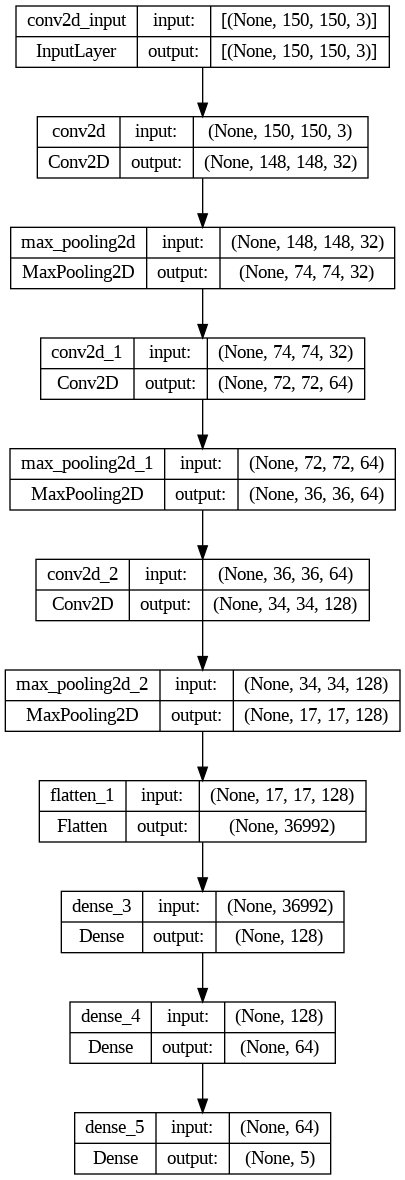

In [ ]:
keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.compile(optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics = ['accuracy'])

In [ ]:
history = model.fit(training_set,
                    validation_data=test_set,
                    epochs=10)

Epoch 1/10
378/378 [==============================] - 66s 170ms/step - loss: 0.0969 - accuracy: 0.9835 - val_loss: 0.0712 - val_accuracy: 0.9873
Epoch 2/10
378/378 [==============================] - 56s 146ms/step - loss: 0.0754 - accuracy: 0.9899 - val_loss: 0.2088 - val_accuracy: 0.9565
Epoch 3/10
378/378 [==============================] - 62s 162ms/step - loss: 0.0377 - accuracy: 0.9901 - val_loss: 0.0528 - val_accuracy: 0.9901
Epoch 4/10
378/378 [==============================] - 53s 138ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.0307 - val_accuracy: 0.9943
Epoch 5/10
378/378 [==============================] - 52s 137ms/step - loss: 0.0520 - accuracy: 0.9896 - val_loss: 0.0367 - val_accuracy: 0.9933
Epoch 6/10
378/378 [==============================] - 53s 139ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 0.0420 - val_accuracy: 0.9933
Epoch 7/10
378/378 [==============================] - 53s 138ms/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.0367 - val_ac

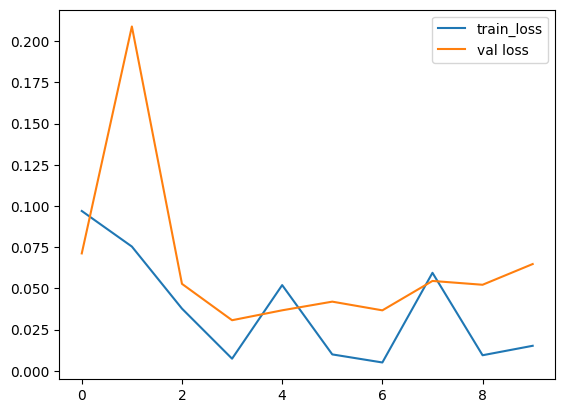

In [ ]:
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

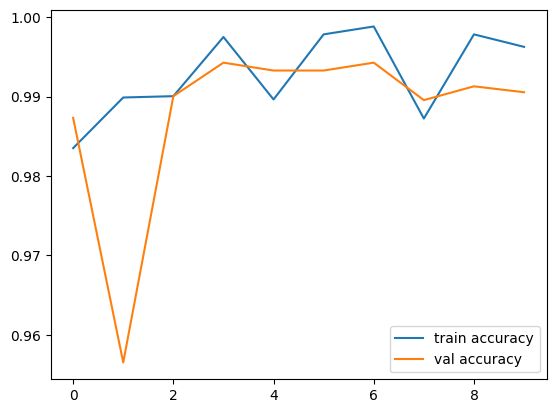

In [ ]:
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.legend()
plt.show()

In [ ]:
# Save it as a h5 file
from tensorflow.keras.models import load_model



In [ ]:
def unseen_data_test(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class_index = tf.argmax(predictions[0], axis=-1)
    predicted_class = class_names[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f'Predicted class: {predicted_class}')
    for i, class_name in enumerate(class_names):
        print(f'Probability of {class_name}: {predictions[0][i]:.4f}')

    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.title(f'Predicted class: {predicted_class}')
    plt.show()

1/1 [==============================] - 0s 72ms/step
Predicted class: SpeedLimit
Probability of Cautions: 0.0000
Probability of Crossings: 0.0000
Probability of DIrection: 0.0000
Probability of No Entry: 0.0000
Probability of SpeedLimit: 1.0000


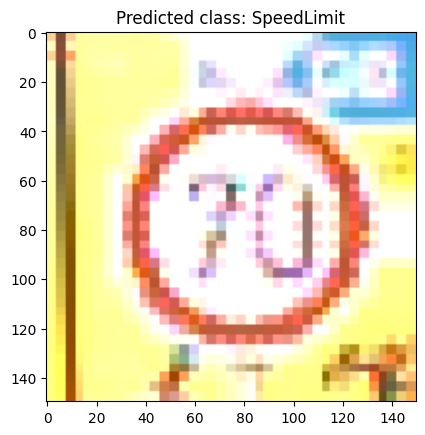

In [ ]:
unseen_data_test("/content/drive/MyDrive/Traffic_Sign_-2/Test/abc/00004_00002_00011.png", model)

1/1 [==============================] - 0s 17ms/step
Predicted class: SpeedLimit
Probability of Cautions: 0.0000
Probability of Crossings: 0.0000
Probability of DIrection: 0.0000
Probability of No Entry: 0.0000
Probability of SpeedLimit: 1.0000


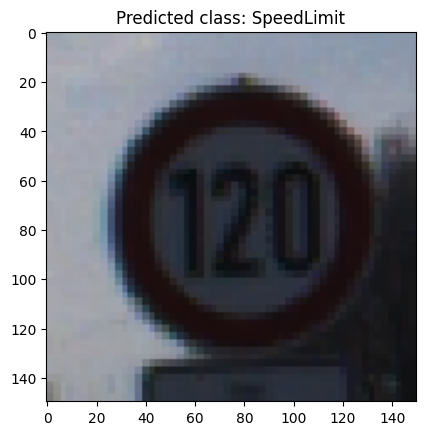

In [ ]:
unseen_data_test("/content/drive/MyDrive/Traffic_Sign_-2/Test/abc/00008_00013_00018.png", model)

1/1 [==============================] - 0s 30ms/step


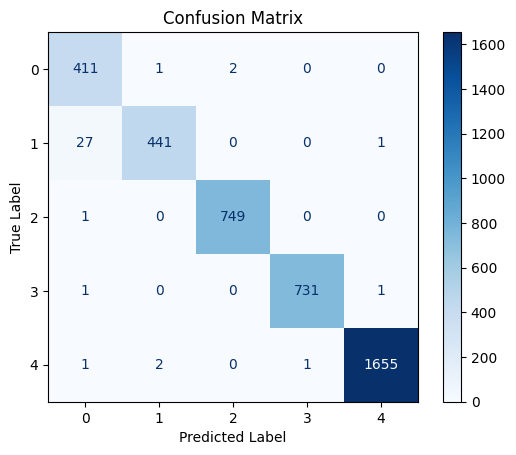

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Define a function to get true labels and predicted labels for the test set
def get_true_and_predicted_labels(test_set, model):
    true_labels = []
    predicted_labels = []
    for images, labels in test_set:
        true_labels.extend(labels.numpy())
        predictions = model.predict(images)
        predicted_labels.extend(np.argmax(predictions, axis=1))
    return true_labels, predicted_labels

true_labels, predicted_labels = get_true_and_predicted_labels(test_set, model)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
labels = [str(i) for i in range(len(class_names))]  # Assuming class names are numeric
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
